# Advanced Optimizers using Fashion-MNIST

**Author**: Tianxiang (Adam) Gao <br>
**Course**: CSC 383/483: Applied Deep Learning <br>
**Description**: In this assignment, you will investigate how different optimization algorithms affect the training dynamics and final performance of a neural network on the **Fashion-MNIST** dataset using the **Keras deep learning library**. The Fashion-MNIST dataset contains 70,000 grayscale images of clothing items (such as shirts, shoes, and bags), each of size 28×28 pixels across 10 categories.

You will train a simple multilayer perceptron (MLP) model using several optimizers—**SGD**, **SGD with Momentum**, **RMSprop**, and **Adam**—while keeping the network architecture, data, and initialization fixed. By comparing their learning curves and test accuracies, you will gain intuition about how optimizer choice influences convergence speed, stability, and generalization.



## Setup

We will first import some useful libraries:
- `numpy` for numerical operations (e.g., arrays, random sampling).
- `keras` for loading the MNIST dataset and building deep learning models.
- `keras.layers` provides the building blocks (dense layers, convolutional layers, activation functions, etc.) to design neural networks.
- `matplotlib` for visualizing images and plotting graphs.

In [24]:
import numpy as np
import keras
from keras import layers
import matplotlib.pyplot as plt

## Prepare the Data [5/5]

1. Use `keras.datasets.fashion_mnist.load_data()` to load the **Fashion-MNIST** training and testing sets.  
2. Normalize all pixel values from integers in the range **[0, 255]** to floating-point numbers between **0 and 1**.  

**Note**:  
In contrast to **Assignment 1**, we **do not** use `np.expand_dims()` to add a channel dimension because MLPs operate on flattened feature vectors rather than image tensors. Similarly, we **do not** convert labels to one-hot encoding, since we will use the loss function `"sparse_categorical_crossentropy"`, which expects integer labels directly.


In [25]:
# load the Fashion-MNIST training and testing sets
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# normalize all pixels from integers to floating point numbers
x_train = x_train.astype('float') / 255
x_test = x_test.astype('float') / 255

print("x_train shape:", x_train.shape)
num_classes, input_shape = 10, x_train.shape[1:]
print("num_classes:", num_classes)
print("input_shape:", input_shape)

x_train shape: (60000, 28, 28)
num_classes: 10
input_shape: (28, 28)


## Visualize the Data [5/5]

3. Randomly pick 9 images from the training set `x_train`. Display them in a 3×3 grid using Matplotlib (`plt.subplot`). For each image, show its corresponding digit label (from `y_train`) as the subplot title.


In [26]:
np.random.choice(len(x_train), 9, replace=False)

array([40640, 15885, 22165, 45417, 43915, 47504, 30852, 47659,  1723])

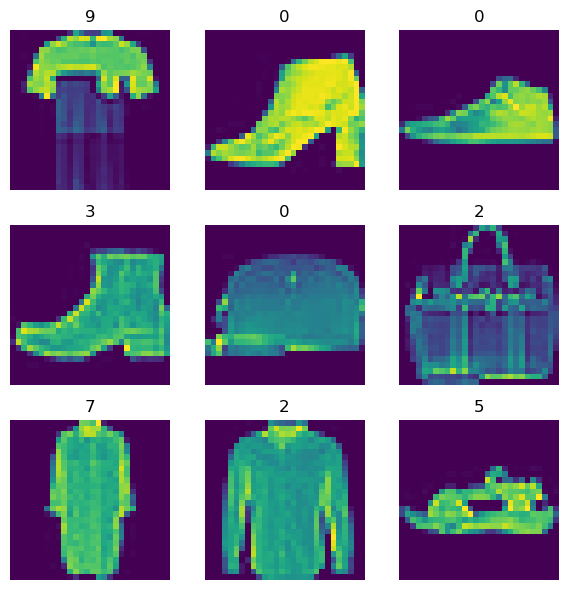

In [27]:
indices = np.random.choice(len(x_train), 9, replace=False)

plt.figure(figsize=(6, 6))
for i, idx in enumerate(indices):
    plt.subplot(3, 3, i + 1)
    # squeeze last channel back to 2D for grayscale display
    plt.imshow(np.squeeze(x_train[idx]))
    # show the integer label, not one-hot
    plt.title(y_train[i])
    plt.axis("off")

plt.tight_layout()
plt.show()

## Build the Model [30/30]

4. Implement a helper function `make_model(num_classes, input_shape)` that returns a simple two-layer MLP built by `keras.Sequential` with the following layers:
    - Input layer: accepts images of shape `input_shape`.
    - Flatten layer: converts each 2D image into a 1D vector.
    - Dense layer: fully connected layer with 128 hidden units and a `"sigmoid"` activation function.
    - Output layer: fully connected layer with `num_classes` units (one for each digit 0–9) and `"softmax"` activation.

5. Create a `base_model` using your helper function and inspect the model by calling `model.summary()` to display the network architecture, output shapes, and number of parameters in each layer.

6. Save the `initial_weights` of the `base_model` for reuse in optimizer comparisons.


In [28]:
def make_model(num_classes, input_shape):
    model = keras.Sequential([
        layers.Input(input_shape),
        layers.Flatten(),
        layers.Dense(128, activation='sigmoid'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

base_model = make_model(num_classes, input_shape)
base_model.summary()

initial_weights = base_model.get_weights()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

## Define Optimizer Function [10/10]

7. To easily switch between different optimization algorithms, we will define a helper function `get_optimizer(name, lr=1e-3)` that returns the corresponding Keras optimizer object based on its name. Implement the function with the following behavior:
   - `"sgd"`: Standard **stochastic gradient descent (SGD)**.  
   - `"momentum"`: **SGD with momentum** (momentum = 0.9).  
   - `"rmsprop"`: **RMSprop** optimizer (adaptive learning rate).  
   - `"adam"`: **Adam** optimizer (adaptive learning rate + momentum).  
   - Raise a `ValueError` if the name is unknown.


In [29]:
def get_optimizer(name, lr=1e-3):
    if name == "sgd":
        return keras.optimizers.SGD(learning_rate=lr)
    elif name == 'momentum':
        return keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
    elif name == 'rmsprop':
        return keras.optimizers.RMSprop(learning_rate=lr)
    elif name == 'adam':
        return keras.optimizers.Adam(learning_rate=lr)
    else:
        raise ValueError(f"Unknown optimizer: {name}")

## Train and Compare Optimizers [30/30]

8. We will write a helper function `train(name, batch_size=128, epochs=20)` to train the model with a specified optimizer, then loop over several optimizers to collect their training histories for plotting:
   - Recreate a fresh model via `make_model(...)`.
   - **Reset** to the same `initial_weights` to ensure a fair start.
   - Build the optimizer with `get_optimizer(name)`.
   - `compile` with `loss="sparse_categorical_crossentropy"` and `metrics=["accuracy"]`.
   - `fit` on `(x_train, y_train)` with `validation_data=(x_test, y_test)`.
   - **Return** the `History` object.

9. **Compare optimizers**:
   - Create a list `optimizers = ["sgd", "momentum", "rmsprop", "adam"]`.
   - For each name, call `train(name, ...)` and store the returned history in a dictionary `histories[name]`.

In [30]:
def train(name, batch_size=128, epochs=20):
  model = make_model(num_classes, input_shape)
  model.set_weights(initial_weights)
  opt = get_optimizer(name)
  model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  print(f"\n===Training with {name}===")
  hist = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))
  return hist

In [31]:
optimizers = ["sgd", "momentum", "rmsprop", "adam"]
histories = {}
for opt in optimizers:
  histories[opt] = train(opt)


===Training with sgd===
Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2068 - loss: 2.2564 - val_accuracy: 0.3444 - val_loss: 2.1455
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4557 - loss: 2.0820 - val_accuracy: 0.5281 - val_loss: 2.0254
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5569 - loss: 1.9712 - val_accuracy: 0.5848 - val_loss: 1.9226
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5938 - loss: 1.8735 - val_accuracy: 0.6058 - val_loss: 1.8310
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6159 - loss: 1.7861 - val_accuracy: 0.6178 - val_loss: 1.7489
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6284 - loss: 1.7078 - val_accuracy: 0.6349 - val_loss: 1.6752
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6407 - loss: 1.6373 - val_accuracy: 0.6466 - val_loss: 1.6087
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6533 - loss: 

## Plot Training and Test Loss [10/10]

10. We will now visualize the **training and test loss curves** for all optimizers on a single plot. Write a function `plot_histories(histories, optimizers, log_scale=False)` that:
   - Creates a new figure using `plt.figure(figsize=(8,5))`.
   - Iterates through each optimizer in the list.
   - Plots both **training loss** (solid line) and **test loss** (dashed line) for the same color.
   - Adds axis labels, title, legend, and grid lines.
   - Optionally uses a logarithmic y-axis if `log_scale=True` (use `plt.yscale("log")`).

11. Call the function twice:
   - Once with the default linear scale.  
   - Once with `log_scale=True` to observe convergence differences in early epochs.

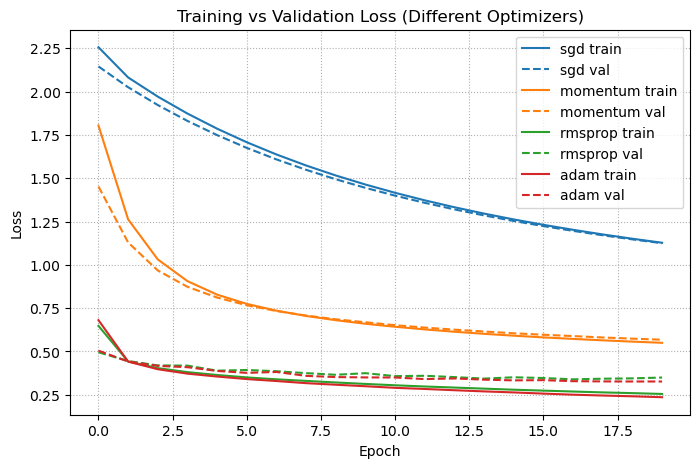

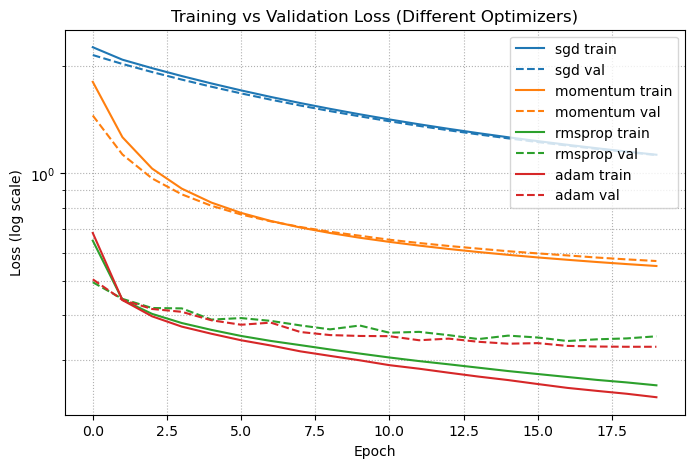

In [51]:
def plot_histories(histories, optimizers, log_scale=False):
    plt.figure(figsize=(8,5))
    colors = plt.cm.tab10.colors

    for i, opt in enumerate(optimizers):
        color = colors[i % len(colors)]
        plt.plot(histories[opt].history['loss'], ls='-', c=color, label=f'{opt} train')
        plt.plot(histories[opt].history['val_loss'], ls='--', c=color, label=f'{opt} val')

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss (Different Optimizers)")
    plt.legend()
    plt.grid(True, which="both", ls=":")
    if log_scale:
        plt.yscale("log")
        plt.ylabel("Loss (log scale)")
    plt.show()

# Example calls
plot_histories(histories, optimizers)              # linear scale
plot_histories(histories, optimizers, log_scale=True)  # log scale

## Interpretation and Discussion [10/10]

Write a short reflection (3–5 sentences) interpreting your results.

**Note**:  
Your explanation should focus on what you observe from the **training and validation curves** rather than theoretical definitions.  
Be concise but specific — mention patterns you can clearly see in your plots and test results.
